In [125]:
import numpy as np
import multiprocess as mp
import statsmodels.stats.api as sms
from math import ceil
from tqdm import tqdm

In [126]:
from src.bootstrap import bootstrap_ci
from src.perm_test import search
from src.utils import partition

---

In [127]:
# https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.CompareMeans.tconfint_diff.html
def tconfint(alpha, x1, x2, pooled=True, alternative="two-sided"):
    cm = sms.CompareMeans(sms.DescrStatsW(x1), sms.DescrStatsW(x2))
    return cm.tconfint_diff(alpha, alternative, usevar="pooled" if pooled else "unequal")

In [128]:
def passToThread(start_idx, end_idx, two_sided=True, pooled=True, method="permutation", alpha=0.05):

    def invert_test(idx, alternative, method="permutation"):
        x1, x2 = x1s[idx], x2s[idx]
        if method == "t":
            lower, upper = tconfint(alpha, x1, x2, pooled, alternative)
            return lower, upper
        
        t99 = tconfint(0.001, x1, x2, pooled, alternative)
        t90 = tconfint(0.20, x1, x2, pooled, alternative)        
        lower, upper = -np.inf, np.inf
        if alternative != "smaller":
            lower = search(x1, x2, partitions, t99[0], t90[0], pooled=pooled, alternative=alternative)
        if alternative != "larger":
            upper = search(x1, x2, partitions, t90[1], t99[1], pooled=pooled, alternative=alternative)
        return lower, upper

    n_captured = n_error = 0
    for i in range(start_idx, end_idx):
        try:
            if two_sided:
                lower, upper = invert_test(i, "two-sided", method)
            else:
                lower1, upper1 = invert_test(i, "smaller", method)
                lower2, upper2 = invert_test(i, "larger", method)
                lower, upper = max(lower1, lower2), min(upper1, upper2)
        except AssertionError:
            n_error += 1
            continue
        n_captured += (lower <= delta_true) * (delta_true <= upper)
    return n_captured, n_error

In [154]:
def simulate(coverages, i, two_sided=True, pooled=True, method="permutation"):
    pool = mp.Pool(mp.cpu_count())
    results = pool.starmap(passToThread, [(i * batch_size, min(total, i * (batch_size+1)),\
                                           two_sided, pooled, method) for i in range(n_batches)])
    pool.close()
    pool.join()
    results = np.array(results).sum(axis=0)
    if not results[1]:
        coverages[i].append(results[0] / total)

---

In [130]:
n1, n2 = 12, 8
partitions = partition(n1, n2)
partitions

array([[ 0,  1,  2, ..., 17, 18, 19],
       [ 0,  1,  2, ..., 17, 18, 19],
       [ 0,  1,  2, ..., 17, 18, 19],
       ...,
       [ 7,  8, 10, ...,  5,  6,  9],
       [ 7,  9, 10, ...,  5,  6,  8],
       [ 8,  9, 10, ...,  5,  6,  7]])

In [148]:
np.random.seed(123)
gammas = np.random.randint(1, 11, (1,2,2))

---

In [166]:
total = 1000  # num. samples per gamma
batch_size = mp.cpu_count()
n_batches = ceil(total/batch_size)

In [167]:
def get_coverages(coverages, g):
    global x1s, x2s, delta_true
    np.random.seed(123)
    # global variables
    x1s = np.random.gamma(g[0,0], g[0,1], (total, n1))
    x2s = np.random.gamma(g[1,0], g[1,1], (total, n2))
    delta_true = (g[0,0] * g[0,1]) - (g[1,0]*g[1,1])  # true mean difference
    
    i = 0
    processes = []
    for two_sided in [True, False]:
        for pooled in [True, False]:
            for method in ["permutation", "t"]:
                # print(f"two_sided: {two_sided}, pooled: {pooled}, method: {method}")
                #sub_l = manager.list(coverages[i])
                #sub_l.append(simulate(two_sided, pooled, method))
                #coverages[i] = sub_l
                p = mp.Process(target=simulate, args=(coverages, i, two_sided, pooled, method))
                processes.append(p)
                p.start()
                i += 1
    for p in processes:
        p.join()

In [ ]:
%%time

manager = mp.Manager()
coverages = manager.list([manager.list() for _ in range(8)])

for g in gammas:
    p = mp.Process(target=get_coverages, args=(coverages, g))
    processes.append(p)
    p.start()

for p in processes:
    p.join()

In [162]:
for coverage in coverages:
    print(list(coverage))

[0.68]
[0.68]
[0.7]
[0.69]
[0.68]
[0.67]
[0.68]
[0.65]


In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

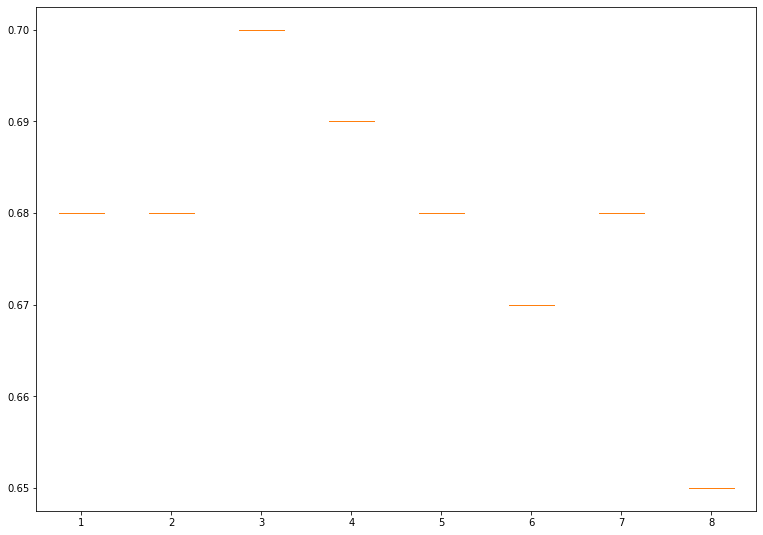

In [153]:
coverages = [list(sublist) for sublist in coverages]  # convert to regular list of lists
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(coverages)